(6750281, 6)
         Timestamp     Open     High      Low    Close    Volume
6750280        NaN  57854.0  57864.0  57835.0  57835.0  1.353466
            Timestamp       Open       High        Low      Close    Volume
0        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
1        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
2        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
3        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
4        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
...               ...        ...        ...        ...        ...       ...
6750275  1.737936e+09  102518.00  102559.00  102506.00  102558.00  0.771165
6750276  1.737936e+09  102628.00  102669.00  102608.00  102611.00  0.086742
6750277  1.737936e+09  102659.00  102712.00  102657.00  102712.00  0.488757
6750278  1.737936e+09  102631.00  102631.00  102573.00  102573.00  0.126719
6750279  1.737936e+09

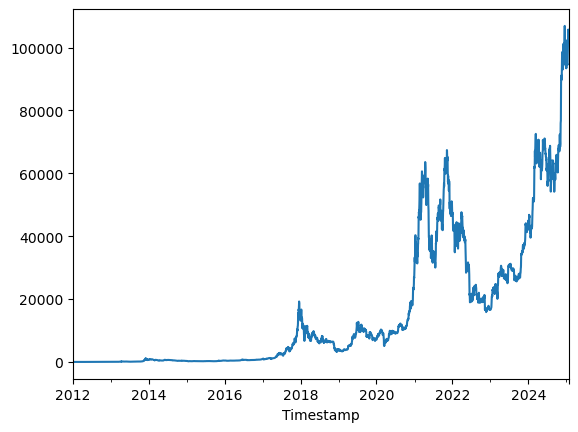

In [1]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as prep
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
# Cargamos el csv
train = pd.read_csv('btcusd_1-min_data.csv')

print(train.shape)

# Mostramos 10 registros al azar
train.sample(10)

#miro donde hay nulls si los hay
train.isna().sum()

filas_con_nulos = train[train.isnull().any(axis=1)]
print(filas_con_nulos)

train = train.dropna()
print(train)

train['Timestamp'] = pd.to_datetime(train['Timestamp'], unit='s') 
train.set_index('Timestamp', inplace=True)
print(train)

# Calcular la media por hora y rellenar posibles nulos
data_hour = train['Close'].resample('d').mean().ffill()

# Visualizamos la serie completa
data_hour.plot()
plt.show()

In [2]:
# 1 año a considerar en el conjunto de test
n_steps = 364

# Dividimos la serie en train y test
train_size = len(data_hour) - n_steps
train, test = data_hour[:train_size], data_hour[train_size:]

In [3]:
# Aplicar auto_arima para encontrar los mejores parámetros
m=12
modelo_auto = auto_arima(train,seasonal=True, stepwise=True, trace=True, error_action='ignore', m=12 , suppress_warnings=True)


# Mostrar resumen del modelo seleccionado
print(modelo_auto.summary())

# Obtener los parámetros óptimos
p, d, q = modelo_auto.order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=9.13 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=68567.255, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=68406.281, Time=0.63 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=68405.284, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=68566.479, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=68403.484, Time=0.25 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=68405.280, Time=0.57 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.91 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=68403.779, Time=1.00 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=68403.179, Time=0.31 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=68404.986, Time=0.76 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=68404.990, Time=0.76 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.45 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=68395.831, Time=1.47 sec
 ARIMA(1,1,2)(1,0,0)[12

In [4]:
# Ajustamos el modelo ARIMA
model = ARIMA(train, order=(p,d,q)) #poner p d y q en caso de ejecutar auto_arima
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast_index = test.index

C:\Users\g3rm4\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


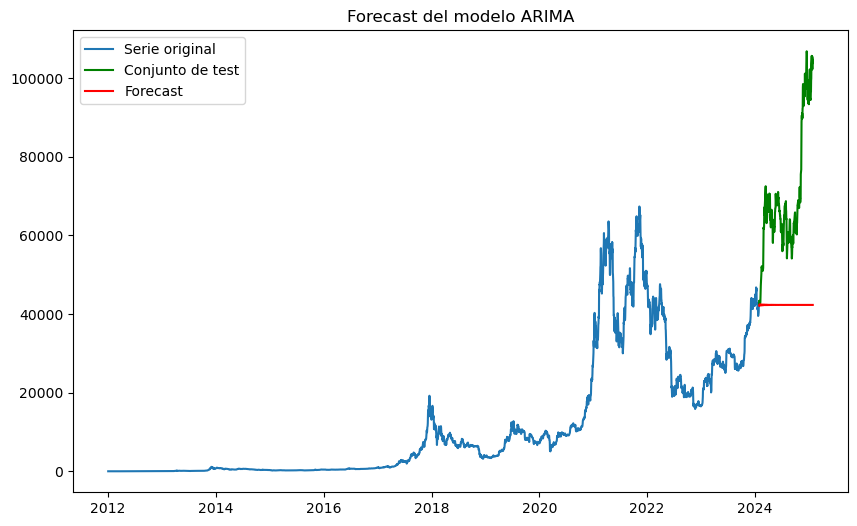

Mean Absolute Error: 27894.494687083392


In [5]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo ARIMA')
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')

In [6]:
model = SARIMAX(train, order=(p, d, q), seasonal_order=(p, d, q, m))
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast_index = test.index

C:\Users\g3rm4\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\g3rm4\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\g3rm4\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


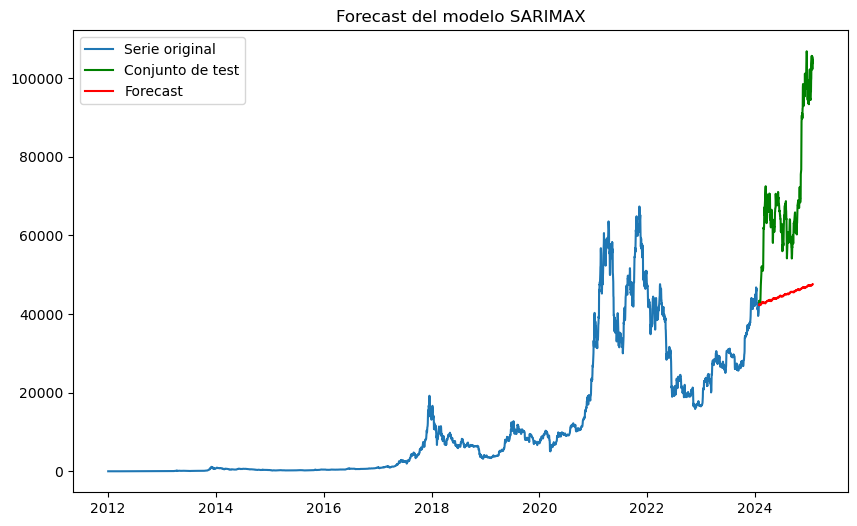

Mean Absolute Error: 25226.227417988564


In [7]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo SARIMAX')
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')